# Code

## Dependencies

In [1]:
import numpy as np
import plotly.graph_objects as go
import drawSvg as draw
from numpy.linalg import matrix_power as mat_pow
import os
import pandas as pd
from datetime import datetime
from scipy.signal import savgol_filter

## Utility functions

In [ ]:
def rot_mat(θ):
    return np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])

def arrow(start, end, stroke_width=0.1, stroke='black', **kwargs):
    start, end = np.array(start), np.array(end)
    Δx = 3
    my_arrow = draw.Marker(-1+Δx/4, -0.5, Δx/4, 0.5, scale=4, orient='auto')
    my_arrow.append(draw.Lines(-1+Δx/4, -0.5, -1+Δx/4, 0.5, Δx/4, 0, close=True, fill=stroke))
    p = draw.Path(stroke=stroke, stroke_width=stroke_width, fill='none',
              marker_end=my_arrow, **kwargs)
    t = 1 - stroke_width*Δx/np.linalg.norm(end-start)
    return p.M(*start).L(*(t*(end-start)+start))

## Drawing

We collect several classes and function which produce SVG (scalable vector graphics) images using the drawSvg module. The main container for an image is always generated in the chapter file which is then filled with svg element groups which can pass on any arguments to its child elements (such as circles, lines etc.).

### Lattice Atom

We introduce a class designed to deal with anything related to individual atoms. We can tell this atom to draw itself and its bonds.

In [ ]:
class LatticeAtom:
    
    
    def __init__(self, position_in_unit_cell, name=None, atom_color='blue', atom_radius=None):       
        self.position = np.array(position_in_unit_cell)
        self.name = name
        self.atom_color = atom_color
        self.atom_radius = atom_radius
        self.bonds = []
        self.bond_style = []
    
    def draw_bonds(self, displacement, θ, **kwargs):
        group = draw.Group()
        origin = rot_mat(θ) @ (displacement + self.position)
        for bond in self.bonds:
            destination = rot_mat(θ) @ (displacement+bond)
            group.append(draw.Line(*origin, *destination, stroke='black', stroke_width=0.01, **kwargs))
        return group
    
    def draw_atom(self, displacement, θ, **kwargs):
        group = draw.Group()
        origin = rot_mat(θ) @ (displacement + self.position)
        gradient = draw.RadialGradient(*origin, self.atom_radius)
        gradient.addStop(0, 'white', 1)
        gradient.addStop(1, self.atom_color, 1)
        group.append(draw.Circle(*origin, self.atom_radius, stroke='black', stroke_width=0.01, fill=gradient, **kwargs))
        if self.name != None:
            group.append(draw.Text(self.name, self.atom_radius, *origin, text_anchor='middle', alignment_baseline="central"))
        return group

### Lattice

We use the atom objects from the previous class to construct any 2d lattice. The procedure to draw a lattice:
1. Create a lattice object by passing both lattice vectors and the width and height of the desired image.
2. For each atom in the unit cell: create an atom object and pass it to the `add_atom` function.
3. Connect two atoms as NN with the `NN` function where the third argument is a list of lattice vectors (eg passing `[(1 0)]` tells the class that the second atom is in the unit cell connected via $1*a_1+0*a_2$).
4. Create a svg group with the `draw_lattice` function and append it to your svg image container.
5. Add lattice vectors and unit cell outline with the `draw_lattice_vectors` and `draw_unit_cell` functions.

In [ ]:
class Index:
 

    def __init__(self, i, j):
        self.i = i
        self.j = j
        
    def __mul__(self, other):
        return self.i * other[0] + self.j * other[1]
    
    def __rmul__(self, other):
        return self * other
        
        
class Lattice:
    
    
    def __init__(self, a_1, a_2, W, H, θ=0):
        self.a = [np.array(a_1), np.array(a_2)]
        self.W = W
        self.H = H
        self.unit_cell = []
        self.grid = []
        self.θ = -θ
        
    def add_atom(self, atom):        
        N_1, N_2 = [1+min(int(self.W/np.abs(a[0]+0.00001)), int(self.H/np.abs(a[1]+0.00001))) for a in [rot_mat(self.θ)@a for a in self.a]]
        self.unit_cell.append(atom)
        if atom.atom_radius == None:
            atom.atom_radius = min([np.linalg.norm(a) for a in self.a]) / min(N_1, N_2) / 5 
        self.grid.append([Index(i, j) for i in range(-N_1, N_1+1) for j in range(-N_2, N_2+1) if self.in_lattice(i, j, atom)])
        
    def in_lattice(self, i, j, atom):
        origin = np.abs(rot_mat(self.θ) @ (atom.position+Index(i, j)*self.a))
        return np.all(origin-atom.atom_radius < [self.W/2, self.H/2])
        
    def NN(self, atom_1, atom_2, bond_list, **kwargs):
        #atom_1.bond_style.append(kwargs)
        for bond in bond_list:
            atom_1.bonds.append(atom_2.position+Index(*bond)*self.a)
            if atom_1 != atom_2:
                #atom_2.bond_style.append(kwargs)
                #atom_2.bonds.append(-atom_1.bonds[-1])
                pass
                
    def draw_lattice(self, origin=(0, 0)):
        group = draw.Group()
        for i, atom in enumerate(self.unit_cell):
            for grid_point in self.grid[i]:
                group.append(atom.draw_bonds(grid_point*self.a, self.θ), z=0)                
                group.append(atom.draw_atom(grid_point*self.a, self.θ), z=1)
        return group
               
    def draw_lattice_vectors(self, vec_symbols=['a₁', 'a₂'], origin=(0, 0), centralize=True, stroke_width=0.1, color='black',
                             **kwargs):
        rot = rot_mat(self.θ)
        group = draw.Group()
        if centralize:
            origin += sum(self.a) / 2
        group.append(arrow(rot@origin, rot@(origin+self.a[0]), stroke_width=stroke_width, stroke=color, **kwargs))
        group.append(arrow(rot@origin, rot@(origin+self.a[1]), stroke_width=stroke_width, stroke=color, **kwargs))
        group.append(draw.Text(vec_symbols[0], stroke_width*10, *(rot@(origin+self.a[0])), fill=color))
        group.append(draw.Text(vec_symbols[1], stroke_width*10, *(rot@(origin+self.a[1])), fill=color))
        return group
    
    def draw_unit_cell(self, origin=(0, 0), **kwargs):
        rot = rot_mat(self.θ)
        group = draw.Group()
        for i in range(2):
            N = int(np.sqrt(self.H**2+self.W**2)/np.linalg.norm(self.a[1-i])) + 1
            for j in range(-N, N+1):
                vector = np.sqrt(self.H**2+self.W**2) * self.a[i]/np.linalg.norm(self.a[i])
                group.append(draw.Line(*(rot@(origin-vector+j*self.a[1-i])), *(rot@(origin+vector+j*self.a[1-i])), **kwargs))
        return group

### Orbitals

The orbital class produces drawings of orbitals which we build from two basic components: lobes and circles. More orbitals might be added later.

In [ ]:
class Orbital:  
    
    
    def lobe(self, color, rotate=0, translate=(0, 0), stroke="black", **kwargs):
        gradient = draw.RadialGradient(0, 1, 0.5)
        gradient.addStop(0, 'white', 0.7)
        gradient.addStop(np.sqrt(3), color, 0.7)
        transform = "translate(" + " ".join([str(i) for i in translate]) + ")\nrotate(" + str(rotate) + " 0 0)"
        my_path = "M 0,0 C " + str(-np.sqrt(3)) + ",-2 " + str(np.sqrt(3)) +",-2 0,0 z"
        return draw.Path(d=my_path, stroke=stroke, stroke_width=0.01, fill=gradient, transform=transform, **kwargs)
    
    def circle(self, color, ellipse=False, rotate=0, translate=(0, 0), stroke="black", **kwargs):
        gradient = draw.RadialGradient(0, 0, 0.5)
        gradient.addStop(0, 'white', 0.7)
        gradient.addStop(np.sqrt(3), color, 0.7)
        transform = "rotate(" + str(rotate) + " 0 0)\ntranslate(" + " ".join([str(i) for i in translate]) + ")"
        if ellipse:
            clip = draw.ClipPath()
            clip.append(draw.Ellipse(0, 0, 0.5, 0.125, transform=transform))
            return draw.Ellipse(0, 0, 1, 0.25, stroke=stroke, stroke_width=0.01, fill=gradient, transform=transform, **kwargs) 
        else:
            return draw.Circle(0, 0, 0.5, stroke=stroke, stroke_width=0.01, fill=gradient, transform=transform, **kwargs)
    
    def d_xy(self, translate=(0, 0), rotate=0, neg_color="dodgerblue", pos_color="red",
             **kwargs):
        group = draw.Group(**kwargs)
        group.append(self.lobe(neg_color, rotate=85+rotate, translate=translate))
        group.append(self.lobe(pos_color, rotate=95+rotate, translate=translate))
        group.append(self.lobe(pos_color, rotate=275+rotate, translate=translate))
        group.append(self.lobe(neg_color, rotate=265+rotate, translate=translate))
        return group
    
    def d_z2(self, translate=(0, 0), rotate=0, neg_color="dodgerblue", pos_color="red",
             **kwargs):
        group = draw.Group(**kwargs)
        group.append(self.lobe(neg_color, rotate=180+rotate, translate=translate))
        group.append(self.circle(pos_color, ellipse=True, rotate=rotate, translate=translate))
        group.append(self.lobe(neg_color, rotate=rotate, translate=translate))
        return group
    
    def d_x2y2(self, translate=(0, 0), rotate=0, neg_color="dodgerblue", pos_color="red",
               **kwargs):
        group = draw.Group(**kwargs)
        group.append(self.lobe(neg_color, rotate=180+rotate, translate=translate))
        group.append(self.lobe(neg_color, rotate=rotate, translate=translate))
        group.append(self.lobe(pos_color, rotate=90+rotate, translate=translate))
        group.append(self.lobe(pos_color, rotate=270+rotate, translate=translate))
        return group

## Band structure

In [2]:
class BandStructure:
    
    def __init__(self):
        self.fig = go.Figure()
        self.fig.update_layout(xaxis_title=r"$k$", yaxis_title= 'Energy (eV)')
          
    def plot_band_structure(self, σ_list=[0], ticks=True, E_ref=None):
        colors = ['blue', 'red', 'green']
        N = len(self.H((0, 0), 1))
        energies = np.zeros((len(self.k_path), N, len(σ_list)))
        for i in range(len(self.k_path)):
            for j in range(len(σ_list)):
                energies[i, :, j] = np.linalg.eigvalsh(self.H(self.k_path[i], σ_list[j]))       
        for j in range(len(σ_list)):
            style_dict = {
                'legendgroup': 'σ='+str(σ_list[j]),
                'mode': 'lines',
                'line': {'color': colors[j]},
                'name': 'σ='+str(σ_list[j])
            }
            fig.add_trace(go.Scatter(y=energies[:, 0, j], **style_dict))
            for i in range(1, N):
                fig.add_trace(go.Scatter(y=energies[:, i, j], showlegend=False, **style_dict))
        return fig
    
    def plot_from_H(self, H, σ_list=[0], color_list=['red']):
        N = len(H((0, 0), 0))
        for i in range(len(σ_list)):
            bands = np.zeros((len(self.k_path), N))
            for j in range(len(self.k_path)):
                bands[j, :] = np.linalg.eigvalsh(H(self.k_path[j], σ_list[i]))
            self.add_bands(bands, color_list[i], 'σ='+str(σ_list[i]))
            
    def add_bands(self, bands, color, name, k_arr=None):
        style_dict = {
                'legendgroup': name,
                'mode': 'lines',
                'line': {'color': color},
                'name': name
            }
        if np.all(k_arr == None):
            k_arr = np.arange(self.N_k)
        for i in range(0, bands.shape[1]):
            self.fig.add_trace(go.Scatter(x=k_arr, y=bands[:, i], showlegend=(i==0), **style_dict))
    
    def set_k_path(self, k_list, k_tags, N_k):
        self.N_k = N_k
        k_norms = [np.linalg.norm(k_list[i+1]-k_list[i]) for i in range(len(k_list)-1)]
        self.spacing = [int(N_k*k_norms[i]/sum(k_norms)) for i in range(len(k_norms))]
        self.k_path = []
        for i in range(len(self.spacing)):
            self.k_path += [k_list[i] + (k_list[i+1]-k_list[i])*j/self.spacing[i] for j in range(self.spacing[i])]
        self.k_path += [k_list[-1]]
        self.fig.update_xaxes(ticktext=k_tags, tickvals=[sum(self.spacing[:i]) for i in range(len(self.spacing)+1)])

In [33]:
class DFT:
    
    def __init__(self, directory, prefix, lattice_vectors, data_dir='dft_data', Δz=32, qe_dic={}, w90_dic={}):
        self.prefix = prefix
        self.dir = directory
        self.data_dir = data_dir
        self.dir_exists(data_dir)
        self.dir_exists(data_dir+'/'+prefix)
        self.dir_exists(data_dir+'/'+prefix+'/w90_orbitals')
        self.cwd = os.getcwd()
        self.a = lattice_vectors
        self.Δz = Δz
        self.qe_dic = {
            '&CONTROL': {
                'prefix': prefix,
                'outdir': './out',
                'verbosity': 'high'
            },
            '&SYSTEM': {
                'assume_isolated': '2D',
                'ibrav': 0,
                'nat': 0,
                'ntyp': 0
            },
            '&ELECTRONS': {}
        }
        for key in qe_dic.keys():
            for sub_key in qe_dic[key].keys():
                self.qe_dic[key][sub_key] = qe_dic[key][sub_key]
        self.w90_dic = {
            'guiding_centres': 'true',
            'write_hr': 'true',
            'wannier_plot': 'true',
            'bands_plot': 'true',
            'wannier_plot_supercell': '3, 3, 1'
        }
        if 'nbnd' in self.qe_dic:
            self.w90_dic['num_bands'] = self.qe_dic['nbnd']
        for key in w90_dic.keys():
            self.w90_dic[key] = w90_dic[key]
        file = "&inputpp\n   outdir = '" + self.qe_dic['&CONTROL']['outdir'] +"'\n   "
        file += "prefix = '" + self.qe_dic['&CONTROL']['prefix'] +"'\n   "
        file += "seedname = '" + self.qe_dic['&CONTROL']['prefix'] +"'\n   "
        file += 'write_unk = .true.\n   write_mmn = .true.\n   write_amn = .true.\n/\n'
        f = open(self.dir+'/'+self.qe_dic['&CONTROL']['prefix']+'.pw2wan', 'w')
        f.write(file)
        f.close()
        
    def dir_exists(self, data_dir):
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
            print('directory created:', data_dir)
        
    def set_atoms(self, atoms):
        self.atoms = atoms
        for atom in atoms.keys():
            for j in range(len(atoms[atom]['loc'])):
                self.atoms[atom]['loc'][j][2] += self.Δz/2
        self.qe_dic['&SYSTEM']['nat'] = sum([len(atom['loc']) for atom in atoms.values()])
        self.qe_dic['&SYSTEM']['ntyp'] = len(atoms)
        
    def set_k_path(self, k_list, k_tags, N_k):
        self.k_list = k_list
        self.k_tags = k_tags
        self.N_k = N_k
        for i in range(len(k_list)):
            k_list[i] = np.array(k_list[i])
        self.band_plot = BandStructure()
        self.band_plot.set_k_path(k_list, k_tags, N_k)
        
    def set_k_grid(self, N):
        self.N_grid = N 
        self.k_grid = [np.array([i/N, j/N, 0]) for i in range(N) for j in range(N)]
    
    def join_grid_point(self, grid_point):
        return '   '.join(['{:.9f}'.format(item)[0:9] for item in grid_point])
    
    def join_k_grid(self, k_grid, qe=True):
        if qe:
            k_str = 'K_POINTS crystal\n' + str(len(k_grid)) + '\n'
            for grid_point in k_grid:
                k_str += '  ' + self.join_grid_point(grid_point) + '  1\n'
        else:
            k_str = ''
            for grid_point in k_grid:
                k_str += '  ' + self.join_grid_point(grid_point) + '\n'
        return k_str
        
    def write_qe_file(self, qe_type):
        file = ''
        self.qe_dic['&CONTROL']['calculation'] = qe_type
        for elem in self.qe_dic.keys():
            file += elem + '\n'
            for sub_elem in self.qe_dic[elem].keys():
                var = self.qe_dic[elem][sub_elem]
                if type(var) == str:
                    var = "'" + var + "'"
                elif type(var) == bool:
                    var =str(var).lower()
                else:
                    var = str(var)
                file += '  ' + sub_elem + ' = ' + var + '\n'
            file += '/\n'
        file += 'CELL_PARAMETERS angstrom\n'
        for a_i in self.a + [(0, 0, self.Δz)]:
            file += '  ' + self.join_grid_point(a_i) + '\n'
        file += 'ATOMIC_SPECIES\n'
        for atom in self.atoms.keys():
            file += '  ' + '   '.join([atom, str(self.atoms[atom]['weight']), "'"+self.atoms[atom]['pseudo']+"'"]) + '\n'
        file += 'ATOMIC_POSITIONS angstrom\n'
        for atom in self.atoms.keys():
            for site in self.atoms[atom]['loc']:
                file += '  ' + atom + '   ' + self.join_grid_point(site) + '\n'
        if qe_type == 'scf':
            file += 'K_POINTS automatic\n  9 9 1 1 1 1'
        elif qe_type == 'nscf':
            file += self.join_k_grid(self.k_grid)
        elif qe_type == 'bands':
            file += self.join_k_grid(self.band_plot.k_path)
        f = open(self.dir+'/'+self.prefix+'.'+qe_type+'.in', "w")
        f.write(file)
        f.close()
        
    def run_qe(self, qe_type, cores=4):
        os.chdir(self.dir)
        file = self.dir+'/'+self.prefix+'.'+qe_type
        startTime = datetime.now()
        print(qe_type, os.system('mpirun -n '+str(cores)+' pw.x < '+file+'.in > '+file+'.out'))
        print(datetime.now()-startTime)
        os.chdir(self.cwd)
        if qe_type == 'bands':
            self.extract_qe_bands()
    
    def extract_qe_bands(self):
        f = open(self.dir+'/'+self.prefix+'.bands.out', "r")
        N_data, band_data = f.read().split("End of band structure calculation")
        f.close()
        N_b = int(N_data.split("number of Kohn-Sham states=")[1].split("\n")[0])
        band_data = band_data.split("k = ")
        qe_bands = np.zeros((self.N_k, N_b))
        for i in range(0, self.N_k):
            k, band_list = band_data[i+1].split("bands (ev):\n\n")
            if i == self.N_k - 1:
                band_list = band_list.split("Writing")[0]
            qe_bands[i, :] = [float(band) for band in band_list.replace("\n", "").split(" ") if band != ""]
        np.save(self.data_dir+'/'+self.prefix +'/qe_bands', qe_bands)
        
    def set_w90_window(self, win_min, win_max, froz_min, froz_max, num_iter):
        self.w90_dic['dis_win_min'] = win_min
        self.w90_dic['dis_win_max'] = win_max
        self.w90_dic['dis_froz_min'] = froz_min
        self.w90_dic['dis_froz_max'] = froz_max
        self.w90_dic['dis_num_iter'] = num_iter
        
    def write_w90_file(self):
        os.chdir(self.dir)
        file = ''
        for key in self.w90_dic.keys():
            file += key + ' = ' + str(self.w90_dic[key]) + '\n'
        file += '\nbegin unit_cell_cart\n'
        for a_i in self.a + [(0, 0, self.Δz)]:
            file += '  ' + self.join_grid_point(a_i) + '\n'
        file += 'end unit_cell_cart\n\nBegin projections'
        for atom in self.atoms.keys():
            if 'projections' in self.atoms[atom]:
                file += '\n  ' + atom +':  ' + '; '.join(self.atoms[atom]['projections'])
        file += '\nEnd projections\n\nBegin atoms_cart\nang\n'
        for atom in self.atoms.keys():
            for site in self.atoms[atom]['loc']:
                file += '  ' + atom + '   ' + self.join_grid_point(site) + '\n'
        file += 'End atoms_cart\n\nBegin Kpoint_Path\n'
        for i in range(len(self.k_tags)-1):
            file += '  ' + self.k_tags[i] + ' ' + self.join_grid_point(self.k_list[i]) + '   '
            file += self.k_tags[i+1] + ' ' + self.join_grid_point(self.k_list[i+1]) + '\n'
        file += 'End Kpoint_Path\n\nmp_grid = ' + str(self.N_grid) +', ' + str(self.N_grid) +', 1'
        file += '\n\nBegin kpoints\n' + self.join_k_grid(self.k_grid, qe=False) + 'End kpoints'
        f = open(self.dir+'/'+self.prefix+'.win', "w")
        f.write(file)
        f.close()
        os.chdir(self.cwd)
        
    def run_w90(self, pp=False, cores=4):
        file = self.dir+'/'+self.prefix
        if pp:
            startTime = datetime.now()
            print('pp', os.system('wannier90.x -pp '+file))
            print(datetime.now()-startTime)
            startTime = datetime.now()
            print('pw2wan', os.system('mpirun -n '+str(cores)+' pw2wannier90.x < '+file+'.pw2wan > '+self.dir+'/pw2wan.out'))
            print(datetime.now()-startTime)
        startTime = datetime.now()
        print('w90', os.system('wannier90.x '+file))
        print(datetime.now()-startTime)
        f = open(self.dir+'/'+self.prefix+'_band.dat', "r")
        w90_bands = np.array([[[float(x) for x in elem.split(" ") if x!=""] for elem in lst.split("\n") if elem!=""] for lst in f.read().split("\n  \n") if lst!=""])
        f.close()
        f = open(self.dir+'/'+self.prefix+'_hr.dat', "r")
        hop_list = np.array([[float(item) for item in lst.split("   ") if item!=''] for lst in f.read().split("\n")[8:-1]])
        f.close()
        np.save(self.data_dir+'/'+self.prefix +'/hopping_elements', hop_list)
        self.extract_w90_bands()
        self.extract_orbitals()
        
    def extract_w90_bands(self):
        f = open(self.dir+'/'+self.prefix+'_band.dat', "r")
        w90_bands = np.array([[[float(x) for x in elem.split(" ") if x!=""] for elem in lst.split("\n") if elem!=""] for lst in f.read().split("\n  \n") if lst!=""])
        my_shape = np.shape(w90_bands)
        f.close()
        f = open(self.dir+'/'+self.prefix+'_band.gnu', "r")
        x_ticks = [elem.split("  ") for elem in (f.read().split("(")[1]).split(")")[0].split(",")]
        f.close()
        k_tags = [elem[0].split('"')[1] for elem in x_ticks]
        k_vals = [float(elem[1])-0.0001 for elem in x_ticks]
        n_ticks = [np.where(w90_bands[0, :, 0] >= k)[0][0] for k in k_vals[:-1]]
        n_ticks += [len(w90_bands[0, :, 0])-1]
        x_arr = []
        ticks = [sum(self.band_plot.spacing[:i]) for i in range(len(self.band_plot.spacing)+1)]
        for i in range(len(ticks)-1):
            Δx = ticks[i+1] - ticks[i]
            Δn = n_ticks[i+1] - n_ticks[i]
            x_arr += [n*Δx/Δn+ticks[i] for n in range(Δn)]
        x_arr += [self.N_k-1]
        np.save(self.data_dir+'/'+self.prefix +'/w90_bands', w90_bands[:, :, 1].T)
        np.save(self.data_dir+'/'+self.prefix +'/w90_band_ticks', np.array(x_arr))
        #self.band_plot.add_bands(w90_bands[:, :, 1].T, color, 'w90 bands', k_arr=np.array(x_arr))
        
    def create_H(self, NN_list):
        f = open(self.dir+'/'+self.prefix+'_hr.dat', "r")
        n_wan = int(f.read().split("\n")[1])
        n_NN = len(NN_list)
        hop_list = np.array([[float(item) for item in lst.split("   ") if item!=''] for lst in f.read().split("\n")[8:-1]])
        hopping = np.zeros((n_NN, n_wan, n_wan), dtype=complex)
        test = 0
        f.close()
        for i, vec in enumerate(NN_list):
            for hop in hop_list:
                if np.all(vec == hop[0:2]):
                    test += 1
                    hopping[i, int(hop[3])-1, int(hop[4])-1] = hop[5] + hop[6]*1j
        if test != n_wan**2*n_NN:
            print("Not all hoppings found", test)
        self.H = lambda k, σ: sum([hopping[i] * np.exp(2*np.pi*1j*(NN[0]*k[0]+NN[1]*k[1])) for i, NN in enumerate(NN_list)])
        self.band_plot.plot_from_H(self.H)
        
    def extract_orbitals(self):
        coordinates = []
        for i in range(1, w90_dic['num_wann']+1):
            f = open(self.dir+'/'+self.prefix+'_'+str(i).zfill(5)+'.xsf', "r")
            coord, data = f.read().split('BEGIN_DATAGRID_3D_UNKNOWN\n')
            f.close()
            coord = np.array([float(item) for item in coord.split('PRIMCOORD\n')[1].split('\n')[i].split('  ')[1:] if item!=''])
            coordinates.append(coord)
            data = data.split('\n')
            N_grid = np.array([int(item) for item in data[0].split(' ') if item!=''], dtype=int)
            wan_origin = [float(item) for item in data[1].split(' ') if item!='']
            vec_span = np.array([[float(item) for item in data[i+2].split(' ') if item!=''] for i in range(3)])
            if i==1:
                np.save(self.data_dir+'/'+self.prefix +'/N_w90_grid_points', N_grid)
                np.save(self.data_dir+'/'+self.prefix +'/w90_grid_origin', wan_origin)
                np.save(self.data_dir+'/'+self.prefix +'/w90_vec_span', vec_span)
            iso_vals = np.array([float(item) for row in data[5:-3] for item in row.split(' ') if item!='']).reshape(*reversed(N_grid))
            n = int(N_grid[2]*((vec_span[2, 2]-coord[2])/vec_span[2, 2])) + 1
            Δn = int(N_grid[0]/2)
            np.save(self.data_dir+'/'+self.prefix +'/w90_orbitals/orbital_'+str(i), np.swapaxes(iso_vals[n-Δn:n+Δn+(2*Δn!=N_grid[0]), :, :], 0, 2))
        np.save(self.data_dir+'/'+self.prefix +'/w90_orbitals/orbital_centers', np.array(coordinates))
            
    def convert_grid(self, A):
        n = A.shape[0]
        grid = np.zeros((3*n, n, n))
        for i in range(n):
            for j in range(n):
                grid[n+2*i-j, j, :] = A[i, j, :]
                if i != n-1:
                    grid[n+2*i-j+1, j, :] = (A[i, j, :]+A[i+1, j, :]) / 2
        return grid
    
    def plot_bands(self):
        qe_path = self.data_dir+'/'+self.prefix +'/qe_bands.npy'
        w90_path = self.data_dir+'/'+self.prefix +'/w90_bands.npy'
        w90_ticks = self.data_dir+'/'+self.prefix +'/w90_band_ticks.npy'
        print(os.getcwd(), qe_path)
        if os.path.exists(qe_path):
            self.band_plot.add_bands(np.load(qe_path), 'blue', 'qe_bands')
        if os.path.exists(w90_path):
            self.band_plot.add_bands(np.load(w90_path), 'green', 'w90_bands', k_arr=w90_ticks)
    
    def plot_wannier(self):
        fig = go.Figure()
        iso_max = 0.9*np.min([np.amax(iso[1]) for iso in self.iso_values])            
        n = self.N_wan[0]
        X, Y, Z = np.mgrid[0:1:3j*n, 0:1:1j*n, 0:1:1j*n]
        factors = sum([np.abs(self.vec_span[i]) for i in range(3)])
        x, y, z = [axis*factors[i]+self.wan_origin[i] for i, axis in enumerate([X, Y, Z*n/self.N_wan[2]])]
        fig.update_layout(legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1) 
        )
        for i in range(1, w90_dic['num_wann']+1):
            fig.add_trace(go.Isosurface(
                x=x.flatten(),
                y=y.flatten(),
                z=z.flatten(),
                value=self.convert_grid(self.iso_values[i-1][1]).flatten(),
                isomin=-iso_max,
                isomax=iso_max,
                opacity=0.6,
                surface_count=6,
                caps=dict(x_show=False, y_show=False),
                showlegend=True,
                name='orbital '+str(i)
            ))
        return fig

In [34]:
qe_dic = {
            '&CONTROL': {
                'pseudo_dir': '/home/hidde/hidde/Unige/dft/pseudo/'
            },
            '&SYSTEM': {
                'occupations': 'smearing',
                'smearing': 'mv',
                'degauss': 0.015,  
                'ecutwfc': 45,
                'ecutrho': 180,
                'nbnd': 30
            }
        }
w90_dic = {
    'num_wann': 2,
    'num_bands': 30,
    'num_iter': 2000
}

atoms = {
    'C': {'weight': 12.0107,
         'pseudo': 'C.pbe-n-kjpaw_psl.1.0.0.UPF',
         'loc': [np.array([0, 0, 0]), np.array([0, 1.42, 0])],
          'projections': ['pz']
    }
}

graphene = DFT("/home/hidde/hidde/Unige/dft/graphene", 'graphene', 
           [np.array([2.45951214, 0, 0]), np.array([-1.2297560, 2.130000, 0])], qe_dic=qe_dic, w90_dic=w90_dic)
graphene.set_atoms(atoms)
graphene.set_k_grid(8)
graphene.set_k_path([(0, 0, 0), (0.5, 0, 0), (1/3, 1/3, 0), (0, 0, 0)], ["Γ", "M", "K", "Γ"], 100)
graphene.set_w90_window(-12, 8, -4.3, -4.1, 500)

In [35]:
graphene.plot_bands()
graphene.band_plot.fig

/home/hidde/hidde/Unige/twisted-bilayer-unige/project-book/master-thesis dft_data/graphene/qe_bands.npy


ValueError: 
    Invalid value of type 'builtins.str' received for the 'x' property of scatter
        Received value: 'dft_data/graphene/w90_band_ticks.npy'

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [17]:
"""
for file_type in ['scf', 'nscf', 'bands']:
    graphene.write_qe_file(file_type)
graphene.run_qe('scf')
graphene.run_qe('bands')
graphene.run_qe('nscf')
graphene.run_w90(pp=True)
"""

w90 0
0:00:01.820997


In [38]:
qe_dic = {
            '&CONTROL': {
                'pseudo_dir': '../'
            },
            '&SYSTEM': {
                'occupations': 'fixed', 
                'ecutwfc': 30,
                'ecutrho': 120,
                'lspinorb': True,
                'noncolin': True,
                'nbnd': 36
            }
        }
w90_dic = {
    'num_wann': 6,
    'num_bands': 36,
    'num_iter': 2000,
    'spinors': 'true',
    'wannier_plot_supercell': '3, 3, 1'
}

atoms = {
    'W': {'weight': 183.840,
         'pseudo': 'pslibrary.1.0.0/rel-pbe/PSEUDOPOTENTIALS/W.rel-pbe-spn-rrkjus_psl.1.0.0.UPF',
         'loc': [np.array([0, 0, 0])],
          'projections': ['dxy', 'dz2', 'dx2-y2']
    },
    'Se': {'weight': 78.960,
          'pseudo': 'pseudo/Se_pbe_v1.uspp.F.UPF',
           'loc': [np.array([0, 1.919689645, 1.67871166]), np.array([0, 1.919689645, -1.67871166])]
          }
}

wse2 = DFT("/home/hidde/hidde/Unige/dft/wse2", 'wse2', 
           [np.array([3.325, 0, 0]), np.array([-1.6625, 2.8795344676, 0])], qe_dic=qe_dic, w90_dic=w90_dic)
wse2.set_atoms(atoms)
wse2.set_k_grid(8)
wse2.set_k_path([(0, 0, 0), (0.5, 0, 0), (1/3, 1/3, 0), (0, 0, 0)], ["Γ", "M", "K", "Γ"], 100)
for file_type in ['scf', 'nscf', 'bands']:
    wse2.write_qe_file(file_type)
wse2.set_w90_window(-12, 1, -6, -2.8, 2000)
wse2.write_w90_file()

In [42]:
#wse2.run_qe('scf')
#wse2.run_qe('bands')
#wse2.run_qe('nscf')
wse2.run_w90(pp=False)

w90 0
0:00:09.469395


IndexError: index 2 is out of bounds for axis 0 with size 0

In [45]:
NN = [(0, 1), (1, 1), (-1, -1), (0, -1), (1, 0), (-1, 0)]
NNN = [(1, -2), (-1, 2), (2, 1), (-2, -1), (-1, 1), (1, -1)]
NNNN = [(2*elem[0], 2*elem[1]) for elem in NN]

In [12]:
-5.746346 - -3.203584

-2.5427619999999997

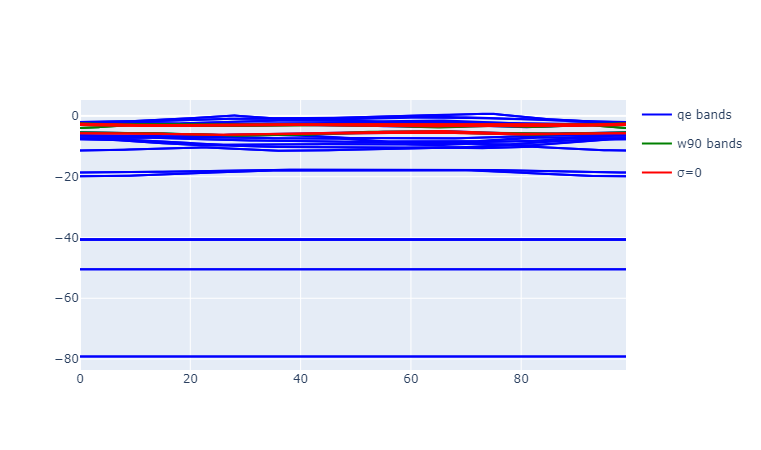

In [46]:
wse2.band_plot.fig = go.Figure()
wse2.extract_qe_bands()
wse2.extract_w90_bands()
wse2.extract_H([(0, 0)]+NN +NNN+NNNN)
#wse2.extract_H(NN)
wse2.band_plot.fig

In [35]:
from scipy.integrate import simps

def kinetic(ψ_1, ψ_2, a, window=5, poly_order=3):
    g = np.linalg.inv([[np.dot(a[i], a[j]) for i in range(3)] for j in range(3)])
    d2ψ = 0
    for i in range(3):
        deriv = savgol_filter(ψ_2, window, poly_order, deriv=1, axis=i, mode='nearest')
        for j in range(3):
            if i == j:
                d2ψ += g[i, j] * savgol_filter(ψ_2, window, poly_order, deriv=2, axis=i, mode='nearest')
            else:
                d2ψ += g[i, j] * savgol_filter(deriv, window, poly_order, deriv=1, axis=j, mode='nearest')
    return simps(simps(simps(ψ_1*d2ψ))) * (1.0545718*10**-34)**2/(2*9.1093837015*10**-31)*10**20*6.242*10**18

window = 7
poly_order = 3

a = [graphene.vec_span[i]/graphene.N_wan[i] for i in range(3)]       
Δh = np.array([(4.8165445+2.4082722)/3/48, 4.1712500/48, 63.8814815/540])    
e_0 = kinetic(graphene.iso_values[0][1], graphene.iso_values[0][1], a, window=window, poly_order=poly_order)
t_0 = kinetic(graphene.iso_values[0][1], graphene.iso_values[1][1], a, window=window, poly_order=poly_order)
t_0 / simps(simps(simps(graphene.iso_values[0][1]**2)))

-4.0826353816835015

In [32]:
def golay(A, m, n):
    for i in range(3):
        A = savgol_filter(A, m, n, axis=i, mode='nearest')
    return A

n = 20
import plotly

orig = graphene.iso_values[0][1]
gol = golay(orig, 7, 3)

fig = plotly.subplots.make_subplots(rows=2, cols=2)
fig.append_trace(go.Heatmap(z=orig[:, :, n]), 1, 1)
fig.append_trace(go.Heatmap(z=gol[:, :, n]), 1, 2)
fig.append_trace(go.Heatmap(z=(orig[:, :, n]-gol[:, :, n])), 2, 1)
fig.show()

AttributeError: module 'plotly' has no attribute 'subplots'

In [ ]:
def convert_grid(A):
    n = A.shape[0]
    grid = np.zeros((3*n, n, n))
    for i in range(n):
        for j in range(n):
            grid[n+2*i-j, j, :] = A[i, j, :]
            if i != n-1:
                grid[n+2*i-j+1, j, :] = (A[i, j, :]+A[i+1, j, :]) / 2
    return grid

X, Y, Z = np.mgrid[-5:5:40j, -5:5:40j, -5:5:40j]

# ellipsoid
values = X * X * 0.5 + Y * Y + Z * Z * 2

fig = go.Figure()

    
fig.add_trace(go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=10,
    isomax=40,
    caps=dict(x_show=False, y_show=False),
    name='hoi',
    showlegend=True
    ))

X, Y, Z = np.mgrid[5:15:40j, -5:5:40j, -5:5:40j]

fig.add_trace(go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=10,
    isomax=40,
    caps=dict(x_show=False, y_show=False),
    showlegend=True
    ))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [ ]:
def V(r):

In [ ]:
def convert_grid(A):
    n = A.shape[0]
    grid = np.zeros((3*n, n, n))
    for i in range(n):
        for j in range(n):
            grid[n+2*i-j, j, :] = A[i, j, :]
            if i != n-1:
                grid[n+2*i-j+1, j, :] = (A[i, j, :]+A[i+1, j, :]) / 2
    return grid

X, Y, Z = np.mgrid[-5:5:40j, -5:5:40j, -5:5:40j]

# ellipsoid
values = X * X * 0.5 + Y * Y + Z * Z * 2

fig = go.Figure()

    
fig.add_trace(go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=10,
    isomax=40,
    caps=dict(x_show=False, y_show=False),
    name='hoi',
    showlegend=True
    ))

X, Y, Z = np.mgrid[5:15:40j, -5:5:40j, -5:5:40j]

fig.add_trace(go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=10,
    isomax=40,
    caps=dict(x_show=False, y_show=False),
    showlegend=True
    ))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [ ]:
i = 10
X, Y, Z = graphene.wannier_grid
fig = go.Figure(data=go.Heatmap(z=data[:, :, i]))
fig.show()

In [ ]:

fig.add_trace(go.Scatter3d(x=[0, 1], y=[0, 0], z=[0, 0], marker=dict(size=5, color=0, colorscale='Viridis'),
                                   line=dict(width=5, color=0, colorscale='Viridis')))
fig.add_trace(go.Scatter3d(x=[0, 1], y=[0, 0], z=[0, 0], marker=dict(size=15, color=0, colorscale='Viridis'),
                                   mode='markers'))
fig.show()

In [18]:
406/540 * (3*32) - 64

8.177777777777777

In [ ]:
np.max()

In [ ]:

X, Y, Z = np.mgrid[-5:5:48j, -5:5:48j, -5:5:48j]

data = graphene.iso_values[0][1]

#data = graphene.convert_grid(data)

fig = go.Figure(data=go.Isosurface(
    x=(X*np.sqrt(3)).flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=data.flatten(),
    isomin=-10,
    isomax=10,
    opacity=0.6,
    surface_count=6,
    caps=dict(x_show=False, y_show=False)
    ))
fig.show()

## Moiré supercell

In [ ]:
class LatVec:
    # We identify each atom as the two integers i and j which connect it to the origin. 
    # Using a pythonic object we can define how two of these vectors interact.
    a_1 = np.array([1, 0])
    a_2 = np.array([1/2, np.sqrt(3)/2])
    b_1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
    b_2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])
    
    
    def __init__(self, i, j, reciprocal=False, scale=1):
        self.i = i
        self.j = j
        self.scale = scale
        self.reciprocal = reciprocal
        self.vec = self.vectorize()
        
    def __add__(self, other):
        return LatVec(self.i+other.i, self.j+other.j)
    
    def __sub__(self, other):
        return LatVec(self.i-other.i, self.j-other.j)
    
    def __eq__(self, other):
        return (self.i==other.i) & (self.j==other.j)
    
    def __and__(self, other):
        # A simple way to get all hopping vectors from two unit vectors.
        return [self, other.neg(), self.neg()+other.neg(), self.neg(), other, self+other]
    
    def __mul__(self, other):
        if type(other) == LatVec:
            return np.dot(self.vec, other.vec)
        elif type(other) == int:
            return LatVec(self.i*other, self.j*other)
        else:
            return np.dot(self.vec, other)
        
    def __rmul__(self, other):
        return self * other
    
    def neg(self):
        return LatVec(-self.i, -self.j)
    
    def rot(self, θ):
         return np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]]) @ self.vec
    
    def vectorize(self):
        if self.reciprocal:
            return self.scale*(self.i*self.b_1 + self.j*self.b_2)
        else:
            return self.scale*(self.i*self.a_1 + self.j*self.a_2)
        
class Supercell:
    supercell_hop = [(0, 0), (1, 0), (0, -1), (-1, -1), (-1, 0), (0, 1), (1, 1)]
    atom_hop = [(1, 0), (0, 1), (-1, 1), (-1, 0), (0, -1), (1, -1)]

    def __init__(self, m, n):
        self.v = [LatVec(m, n), LatVec(n+m, -m)]
        self.w_1 = LatVec(m, n+m, True, 1/(m**2+m*n+n**2))
        self.w_2 = LatVec(n, -m, True, 1/(m**2+m*n+n**2))
        r = max(m, n)
        self.grid = [LatVec(i, j) for i in range(0, 3*r) for j in range(-r, r+1) if self.in_supercell(i, j)]
        self.N_atoms = len(self.grid)
        self.Δθ = np.arctan((n-m)/(n+m)/np.sqrt(3))
        self.intralayer_NN = []
        for i in range(self.N_atoms):
            self.intralayer_NN.append([self.find_NN(i, LatVec(*h_vec)) for h_vec in self.atom_hop])
        
    def in_supercell(self, i, j, tol=10**-5):
        M = np.linalg.inv(np.array([v.vec for v in self.v]).T)
        λ, μ = M @ LatVec(i, j).vec
        in_parellogram = (tol < λ < 1-tol) and (tol < μ < 1-tol) 
        return in_parellogram or (i, j) == (0, 0)
        
    def find_NN(self, i, h_vec):
        for hop in self.supercell_hop:
            lat_vec = Index(*hop) * self.v
            if self.grid[i]+h_vec-lat_vec in self.grid:
                return [self.grid.index(self.grid[i]+h_vec-lat_vec), *hop]
        raise Exception('No NN found for '+str(i)+' '+str(h_vec))
                                        
    def lattice(self, W, H, rotate=True, NN_intralayer=False, atom_color='blue', atom_radius=0.2):
        supercell = Lattice(*[v.vec for v in self.v], W, H, θ=self.Δθ*rotate)
        for atom in self.grid:
            supercell.add_atom(LatticeAtom(atom.vec, atom_color=atom_color, atom_radius=atom_radius))
        if NN_intralayer:
            for i, atom in enumerate(supercell.unit_cell):
                for NN in self.intralayer_NN[i]:
                        supercell.NN(atom, supercell.unit_cell[NN[0]], [NN[1:]])                                    
        return supercell
    
    def reduce_k_point(self, k):
        α, β = np.linalg.inv([[self.w_1*self.w_1, self.w_1*self.w_2], [self.w_1*self.w_2, self.w_2*self.w_2]]) @ np.array([np.dot(k, self.w_1.vec), np.dot(k, self.w_2.vec)]).T
        return np.modf(α)[0]*self.w_1.vec + np.modf(β)[0]*self.w_2.vec
    
class Bilayer:
    hop_list = [(0, 0), (1, 0), (0, -1), (-1, -1), (-1, 0), (0, 1), (1, 1)]
    
    
    def __init__(self, m, n, tol=10**-5):
        self.layer_1 = Supercell(m, n)
        self.layer_2 = Supercell(n, m)
        if self.layer_1.N_atoms != self.layer_2.N_atoms:
            raise Exception('Supercells have a different number of atoms')
        self.N =  self.layer_1.N_atoms
        if np.abs(self.layer_1.Δθ + self.layer_2.Δθ) > tol:
            raise Exception('Unequal twist angles')
        self.v = [rot_mat(-self.layer_1.Δθ) @ v.vec for v in self.layer_1.v]
        self.interlayer_NN = self.find_interlayer_NN()
               
    def find_interlayer_NN(self, max_distance=1, tol=10**-5):
        interlayer_NN = []
        for i in range(self.N):
            interlayer_NN.append([])
            vec_i = self.layer_1.grid[i].rot(-self.layer_1.Δθ)    
            for j in range(self.N):
                min_ΔR = 10**6
                for hop in self.hop_list:
                    lat_vec = Index(*hop) * self.layer_2.v
                    vec_j_trial = (self.layer_2.grid[j]+lat_vec).rot(-self.layer_2.Δθ)
                    if np.linalg.norm(vec_i-vec_j_trial) < min_ΔR:
                        min_ΔR = np.linalg.norm(vec_i-vec_j_trial)
                        vec_j = vec_j_trial
                        my_hop = hop
                if np.linalg.norm(vec_i - vec_j) < max_distance+tol:
                    interlayer_NN[i].append([j, *my_hop])
        return interlayer_NN
    
    def lattice(self, W, H, atom_color=['blue', 'red'], atom_radius=0.2, NN_interlayer=False, NN_intralayer=False, add_Se2=False,
               Se2_color=['blueviolet', 'coral']):
        bilayer = Lattice(*self.v, W, H)
        Se2_list = []
        for i, layer in enumerate([self.layer_1, self.layer_2]):
            rot = rot_mat(-layer.Δθ)
            for atom in layer.grid:
                bilayer.add_atom(LatticeAtom(rot@atom.vec, atom_color=atom_color[i], atom_radius=atom_radius))
                if add_Se2:
                    pos = atom.vec + (1/2, (1-2*i)/(2*np.sqrt(3)))
                    Se2_list.append(LatticeAtom(rot@pos, atom_color=Se2_color[i], atom_radius=atom_radius/2))
        if NN_interlayer:
            for i, atom in enumerate(bilayer.unit_cell[:self.N]):
                for NN in self.interlayer_NN[i]:
                    bilayer.NN(atom, bilayer.unit_cell[self.N+NN[0]], [NN[1:]])                    
                    bilayer.NN(bilayer.unit_cell[self.N+NN[0]], atom, [[-NN[1], -NN[2]]])
        if NN_intralayer:
            for j, layer in enumerate([self.layer_1, self.layer_2]):
                for i, atom in enumerate(bilayer.unit_cell[j*self.N:(j+1)*self.N]):
                    for NN in layer.intralayer_NN[i]:
                        bilayer.NN(atom, bilayer.unit_cell[self.N*j+NN[0]], [NN[1:]])
        if add_Se2:
            for Se2 in Se2_list:
                bilayer.add_atom(Se2)
        return bilayer

## WSe$_2$

In [ ]:
class WSe2:
    var_dic = {
        "t_1": 0.034, 
        "t_2": 0.263, 
        "t_3": -0.207, 
        "t_12": 0.329, 
        "t_13": 0.486, 
        "t_23": 0.457, 
        "ε_1": 2.179, 
        "ε_3": 0.942, 
        "λ_SOC": 0.228
    }
    t_1, t_2, t_3, t_12, t_13, t_23, ε_1, ε_3, λ_SOC = var_dic.values()
    E_mat = np.array([[t_1, t_12, t_13],
                      [-t_12, t_2, t_23],
                      [t_13, -t_23, t_3]])
    E_levels = np.diag([ε_1, ε_1, ε_3])
    E_0 = E_levels[0, 0] - 3/2*(E_mat[1, 1]+E_mat[0, 0]) - 3*np.sqrt(3)*E_mat[0, 1]
    E_1 = E_levels[2, 2] - 3*E_mat[2, 2]
    λ_SOC = 0.228
    d = 2.4
    λ = 0.3
    
    def __init__(self, m, n, R_max=1):
        """
        self.layer_1 = Supercell(m, n)
        self.layer_2 = Supercell(n, m)
        self.z_hopping = self.layer_1.interlayer_hopping_array(self.layer_2)
        R = np.array([[-1/2, -np.sqrt(3)/2, 0], [np.sqrt(3)/2, -1/2, 0], [0, 0, 1]])
        C_2 = np.diag([1, -1, 1])
        self.E_list = [mat_pow(R, i)@mat_pow(C_2, i)@self.E_mat@(mat_pow(R, i)@mat_pow(C_2, i)).T for i in range(6)]
        z_hopping = self.layer_1.interlayer_hopping_array(self.layer_2)
        self.z_hop = []
        for i in range(self.layer_1.N_atoms):
            self.z_hop += [[(j, z_hopping[i, j]) for j in range(self.layer_2.N_atoms) if np.linalg.norm(z_hopping[i, j])<R_max]]
        """
        pass
        
    def H_mono(self, k, σ):
        k_x, k_y = k[0]/2, k[1]*np.sqrt(3)/2
        cos2x, cosx, cosy = np.cos(2*k_x), np.cos(k_x), np.cos(k_y)
        sin2x, sinx, siny = np.sin(2*k_x), np.sin(k_x), np.sin(k_y)
        h_1 = 2*self.t_1*cos2x + (self.t_1+3*self.t_2)*cosx*cosy
        h_2 = 2*self.t_2*cos2x + (self.t_2+3*self.t_1)*cosx*cosy
        h_3 = 2*self.t_3*cos2x + 4*self.t_3*cosx*cosy
        h_12 = np.sqrt(3)*(self.t_1-self.t_2)*sinx*siny + 2j*self.t_12*(sin2x-2*sinx*cosy)
        h_13 = 2*self.t_13*(cos2x-cosx*cosy) + 2j*np.sqrt(3)*self.t_23*cosx*siny
        h_23 = -2*np.sqrt(3)*self.t_13*sinx*siny + 2j*self.t_23*(sin2x+sinx*cosy)
        return np.array([
            [self.ε_1+h_1, 1j*self.λ_SOC*σ+h_12, h_13],
            [-1j*self.λ_SOC*σ+np.conj(h_12), self.ε_1+h_2, h_23],
            [np.conj(h_13), np.conj(h_23), self.ε_3+h_3]
        ])
    
    def H_WSe2_mono(self, k, σ, layer, rotate=False):
        if rotate:
            k = np.array([[np.cos(layer.Δθ), -np.sin(layer.Δθ)], [np.sin(layer.Δθ), np.cos(layer.Δθ)]]) @ k
        H = np.zeros((3*layer.N_atoms, 3*layer.N_atoms), dtype=complex)
        for i in range(layer.N_atoms):
            H[3*i:3*(i+1), 3*i:3*(i+1)] = self.E_levels + self.λ_SOC*np.array([[0, 1j*σ, 0], [-1j*σ, 0, 0], [0, 0, 0]])
            for j in range(6):
                m = layer.NN_array[i][j]['NN']
                H[3*i:3*(i+1), 3*m:3*(m+1)] = self.E_list[j] * np.exp(1j*np.dot(layer.NN_array[i][j]['LatVec'].vec, k))
        my_H = (sum([self.E_list[j] * np.exp(1j*np.dot(layer.hop_list[j].vec, k)) for j in range(6)]) 
                    + self.E_levels + self.λ_SOC*np.array([[0, 1j*σ, 0], [-1j*σ, 0, 0], [0, 0, 0]]))
        
        return my_H
            
    def H_WSe2_bilayer(self, k, σ, t_0):
        H = np.zeros((6*self.layer_1.N_atoms, 6*self.layer_1.N_atoms), dtype=complex)
        H[0:3*self.layer_1.N_atoms, 0:3*self.layer_1.N_atoms] = self.H_WSe2_mono(k, σ, self.layer_1, rotate=True)
        H[3*self.layer_1.N_atoms:, 3*self.layer_1.N_atoms:] = self.H_WSe2_mono(k, σ, self.layer_2, rotate=True)
        for i in range(self.layer_1.N_atoms):
            for j, hop_vec in self.z_hop[i]:
                t = t_0 * np.exp(-(np.sqrt(np.dot(hop_vec, hop_vec)+self.d**2)-self.d)/self.λ)
                H[3*i+2+3*self.layer_1.N_atoms, 3*j+2] = t * np.exp(1j*np.dot(k, hop_vec))
                H[3*j+2, 3*i+2+3*self.layer_1.N_atoms] = t * np.exp(-1j*np.dot(k, hop_vec))
        return H

In [ ]:
"{:.2f}".format(0)

In [ ]:
import numpy as np
np.zeros((3, 2)).shape[0]

In [ ]:
'hoihoi'[0:4]